  Постройте графики зависимости сходимости (значение функции потерь от количества итераций работы алгоритма)
  от выбора оптимизационного метода
  количество эпох = 50
  Сравните, сделайте выводы
  https://pytorch.org/docs/stable/optim.html

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
# Загрузка данных
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.74MB/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 923kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.03MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.68MB/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [10]:
# Параметры обучения
batch_size = 64
epochs = 50
learning_rate = 1e-3

In [11]:
# Создание загрузчиков данных
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    sum_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    return sum_loss / len(dataloader)

In [14]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

def run_training(epochs, train_dataloader, model, loss_fn, optimizer):
    losses = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss = test_loop(test_dataloader, model, loss_fn)
        losses.append(test_loss)
    print("Done!")
    return losses

In [15]:
# Создание словаря оптимизаторов для тестирования
optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam,
    'RMSprop': torch.optim.RMSprop,
    'Adagrad': torch.optim.Adagrad
}


In [16]:
# Функция потерь
loss_fn = nn.CrossEntropyLoss()



Training with SGD
Epoch 1
-------------------------------
loss: 2.303624 [    0/60000]
loss: 2.285458 [ 6400/60000]
loss: 2.271400 [12800/60000]
loss: 2.262049 [19200/60000]
loss: 2.237713 [25600/60000]
loss: 2.216331 [32000/60000]
loss: 2.213581 [38400/60000]
loss: 2.181095 [44800/60000]
loss: 2.187965 [51200/60000]
loss: 2.149341 [57600/60000]
Test Error: 
 Accuracy: 54.1%, Avg loss: 2.142907 

Epoch 2
-------------------------------
loss: 2.155812 [    0/60000]
loss: 2.141481 [ 6400/60000]
loss: 2.083390 [12800/60000]
loss: 2.099697 [19200/60000]
loss: 2.039593 [25600/60000]
loss: 1.985181 [32000/60000]
loss: 2.014514 [38400/60000]
loss: 1.926397 [44800/60000]
loss: 1.940096 [51200/60000]
loss: 1.869851 [57600/60000]
Test Error: 
 Accuracy: 56.3%, Avg loss: 1.858759 

Epoch 3
-------------------------------
loss: 1.894944 [    0/60000]
loss: 1.862673 [ 6400/60000]
loss: 1.740744 [12800/60000]
loss: 1.784501 [19200/60000]
loss: 1.675922 [25600/60000]
loss: 1.626100 [32000/60000]
los

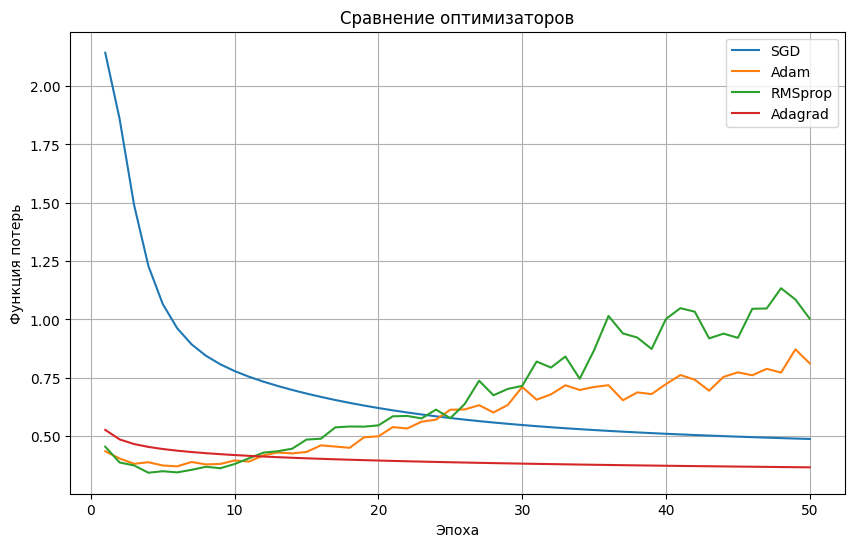

In [17]:
# Обучение с разными оптимизаторами
results = {}
for opt_name, opt_class in optimizers.items():
    print(f"\nTraining with {opt_name}")
    model = NeuralNetwork()
    optimizer = opt_class(model.parameters(), lr=learning_rate)
    losses = run_training(epochs, train_dataloader, model, loss_fn, optimizer)
    results[opt_name] = losses

# Построение графиков
plt.figure(figsize=(10, 6))
for opt_name, losses in results.items():
    plt.plot(range(1, epochs + 1), losses, label=opt_name)
plt.xlabel('Эпоха')
plt.ylabel('Функция потерь')
plt.title('Сравнение оптимизаторов')
plt.legend()
plt.grid(True)
plt.show()